## This notebook will identify the optimal buffer size for each variable 
Amanda Worthy

In [20]:
import osmnx as ox
import geopandas as gpd
import requests
import pandas as pd
from datetime import datetime
import time
import json
import os
from os.path import join, getsize
from pathlib import Path
import glob
from io import StringIO
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, box
import fiona
import pyproj
#import contextily as ctx
import matplotlib.ticker as ticker
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.geocoders import Nominatim
from shapely.ops import unary_union
import rioxarray as rxr
import xarray as xr
from rasterio.enums import Resampling
from affine import Affine
import shapely.geometry
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



In [21]:
!ls

1_create_map_and_buffers_sample_at_sensors.ipynb
2_best_buffer_size.ipynb
README.md
buffered_jan22_some_attributes.csv
buffered_jan22_some_attributesb4lst.csv


In [22]:
data_fxn = '/Users/amandaworthy/Paper3_data_collection/USEFULDATA/energy_data_tmyx_and_location_jan22.csv'

eng = pd.read_csv(data_fxn)

eng

mygeometry_array = gpd.points_from_xy(eng['Longitude (E+/W-)'], eng['Latitude (N+/S-)'])

gdf= gpd.GeoDataFrame(
    eng, crs='EPSG:3395', geometry=mygeometry_array)

gdf.head()

,Total Energy [kBtu],Energy Per Total Building Area [kBtu/ft2],Energy Per Conditioned Building Area [kBtu/ft2],Building,Environment,WMO,Country,State,City/Station,Source Data,Latitude (N+/S-),Longitude (E+/W-),Time Zone (GMT +/-),Elevation (m),URL,geometry
0,51530.00,10.00,21.68,US+SF+CZ4C+hp+unheatedbsmt+IECC_2024,Seattle-Tacoma.Intl.AP WA USA SRC-TMYx WMO#=72...,727930,USA,WA,Seattle-Tacoma.Intl.AP,SRC-TMYx,47.44400,-122.3140,-8,137.0,https://climate.onebuilding.org/WMO_Region_4_N...,POINT (-122.314 47.444)
1,50224.89,9.74,21.13,US+SF+CZ4C+hp+unheatedbsmt+IECC_2024,Alki.Point.Lighthouse WA USA SRC-TMYx WMO#=727939,727939,USA,WA,Alki.Point.Lighthouse,SRC-TMYx,47.57627,-122.4206,-8,1.0,https://climate.onebuilding.org/WMO_Region_4_N...,POINT (-122.421 47.576)
2,51919.64,10.07,21.84,US+SF+CZ4C+hp+unheatedbsmt+IECC_2024,Seattle-Sand.Point.WSFO WA USA SRC-TMYx WMO#=7...,746938,USA,WA,Seattle-Sand.Point.WSFO,SRC-TMYx,47.68619,-122.2605,-8,18.3,https://climate.onebuilding.org/WMO_Region_4_N...,POINT (-122.260 47.686)
3,50074.66,9.72,21.07,US+SF+CZ4C+hp+unheatedbsmt+IECC_2024,Renton.Muni.AP WA USA SRC-TMYx WMO#=727934,727934,USA,WA,Renton.Muni.AP,SRC-TMYx,47.49300,-122.2140,-8,10.0,https://climate.onebuilding.org/WMO_Region_4_N...,POINT (-122.214 47.493)
4,48629.95,9.43,20.46,US+SF+CZ4C+hp+unheatedbsmt+IECC_2024,Seattle WA USA SRC-TMYx WMO#=994014,994014,USA,WA,Seattle,SRC-TMYx,47.60500,-122.3380,-8,2.0,https://climate.onebuilding.org/WMO_Region_4_N...,POINT (-122.338 47.605)


In [23]:
gdf.columns

Index(['Total Energy [kBtu]', 'Energy Per Total Building Area [kBtu/ft2]',
       'Energy Per Conditioned Building Area [kBtu/ft2]', 'Building',
       'Environment', 'WMO', 'Country', 'State', 'City/Station', 'Source Data',
       'Latitude (N+/S-)', 'Longitude (E+/W-)', 'Time Zone (GMT +/-)',
       'Elevation (m)', 'URL', 'geometry'],
      dtype='object')

In [24]:
columns_for_model= ['WMO', 'Latitude (N+/S-)', 'Longitude (E+/W-)', 
       'Elevation (m)', 'geometry', 'Total Energy [kBtu]',]

In [25]:
gdf2= gdf[columns_for_model]
gdf3= gdf2.dropna()

gdf3

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),geometry,Total Energy [kBtu]
0,727930,47.44400,-122.3140,137.0,POINT (-122.314 47.444),51530.00
1,727939,47.57627,-122.4206,1.0,POINT (-122.421 47.576),50224.89
2,746938,47.68619,-122.2605,18.3,POINT (-122.260 47.686),51919.64
3,727934,47.49300,-122.2140,10.0,POINT (-122.214 47.493),50074.66
4,994014,47.60500,-122.3380,2.0,POINT (-122.338 47.605),48629.95
5,994350,47.66200,-122.4353,3.0,POINT (-122.435 47.662),49613.79
6,727935,47.53000,-122.3010,6.0,POINT (-122.301 47.530),50751.23


In [26]:
buffer_data_fxn = 'buffered_jan22_some_attributes.csv'

df = pd.read_csv(buffer_data_fxn)

df.head()

,WMO,Total Energy [kBtu],geometry,buffer_size,streets_intersection,streets_length,avg_canopy,mode_landcover,building_count,water_area,avg_lst
0,727930,51530.00,POLYGON ((-122.31391016847155 47.4439999999999...,10,LINESTRING Z EMPTY,0.000000,NaN,NaN,0,0.000000e+00,NaN
1,727939,50224.89,POLYGON ((-122.4205101684716 47.57626999999999...,10,LINESTRING Z EMPTY,0.000000,NaN,NaN,0,1.712739e-08,NaN
2,746938,51919.64,POLYGON ((-122.26041016847158 47.6861899999999...,10,LINESTRING Z EMPTY,0.000000,NaN,NaN,0,0.000000e+00,NaN
3,727934,50074.66,POLYGON ((-122.21391016847159 47.4929999999999...,10,LINESTRING Z EMPTY,0.000000,NaN,NaN,0,0.000000e+00,NaN
4,994014,48629.95,POLYGON ((-122.33791016847157 47.6049999999999...,10,MULTILINESTRING ((-13618605.633113632 6009811....,31.831183,0.0,24.0,0,0.000000e+00,32.615588


In [27]:
df.columns

Index(['WMO', 'Total Energy [kBtu]', 'geometry', 'buffer_size',
       'streets_intersection', 'streets_length', 'avg_canopy',
       'mode_landcover', 'building_count', 'water_area', 'avg_lst'],
      dtype='object')

In [28]:
import pandas as pd

# List of variables to analyze
variables = ['streets_length', 'avg_canopy', 'mode_landcover', 'building_count',
       'water_area', 'avg_lst']

# Initialize a list to store results
results = []

for var in variables:
    # Select columns for analysis
    cols = ['WMO', 'Total Energy [kBtu]', 'buffer_size', var]
    
    # Filter the DataFrame with the selected columns
    df_var = df[cols]
    
    # Use pivot_table to aggregate by 'Sensor_Number' and 'pm2.5_atm_median' and reshape the DataFrame
    df_wide = df_var.pivot_table(index=['WMO', 'Total Energy [kBtu]'],
                                columns='buffer_size', 
                                values=var,
                                aggfunc='mean') 
    
    # Rename the columns to append the variable name before each buffer size
    df_wide.columns = [f'{var}_{int(col)}' for col in df_wide.columns]
    
    # Reset index to make 'Sensor_Number' and 'pm2.5_atm_median' part of the columns
    df_wide = df_wide.reset_index()
    
    # Calculate the correlation matrix
    corr = df_wide.corr()
    
    # Extract correlations with 'pm2.5_atm_median', starting from index 3 to skip the first non-variable columns
    corr_values = corr['Total Energy [kBtu]'] [3:]
    
    # Find the row index of the absolute maximum correlation
    if not corr_values.empty:
        max_abs_corr_index = corr_values.abs().idxmax()
        best_buffer_size = max_abs_corr_index.split('_')[-1]  # Extract buffer size from column name
        results.append({'Variable': var, 'Best_Buffer_Size': best_buffer_size})

# Convert results to DataFrame
best_buffer_size_df = pd.DataFrame(results)

# Display the results DataFrame
best_buffer_size_df


,Variable,Best_Buffer_Size
0,streets_length,130
1,avg_canopy,970
2,mode_landcover,70
3,building_count,100
4,water_area,730
5,avg_lst,520


In [29]:
# Ensure 'Best_Buffer_Size' is numeric for the dictionary 
best_buffer_size_df['Best_Buffer_Size'] = pd.to_numeric(best_buffer_size_df['Best_Buffer_Size'], errors='coerce')

# Convert the DataFrame to a dictionary
max_corr_at_buffer_dict = best_buffer_size_df.set_index('Variable')['Best_Buffer_Size'].to_dict()

# Display the dictionary
max_corr_at_buffer_dict 


{'streets_length': 130,
 'avg_canopy': 970,
 'mode_landcover': 70,
 'building_count': 100,
 'water_area': 730,
 'avg_lst': 520}

In [31]:
# Initialize an empty DataFrame to store merged results
df_merged = pd.DataFrame()

# Loop over each column and buffer size in the dictionary
for column, buffer_size in max_corr_at_buffer_dict.items():
    # Filter the DataFrame for the optimized buffer sizes
    df_filtered = df[df['buffer_size'] == buffer_size]
    
    # Select the 'year', 'Sensor_Number', and the current column
    df_selected = df_filtered[['WMO', column]].copy()
    
    # Rename the column to append the buffer size (e.g., 'highway_length_200')
    df_selected.rename(columns={column: f'{column}_{buffer_size}'}, inplace=True)
    
    # Merge the results with the previously merged DataFrame or start with the first one
    if df_merged.empty:
        df_merged = df_selected
    else:
        df_merged = df_merged.merge(df_selected, on=['WMO'], how='outer')

# Merge the final result with the gdf3 on 'year' and 'Sensor_Number'
gdf_merged = gdf3.merge(df_merged, on=['WMO'], how='left')

# Display or use the final merged GeoDataFrame
gdf_merged.head()

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),geometry,Total Energy [kBtu],streets_length_130,avg_canopy_970,mode_landcover_70,building_count_100,water_area_730,avg_lst_520
0,727930,47.44400,-122.3140,137.0,POINT (-122.314 47.444),51530.00,0.000000,2.044056,0.0,0,0.000000,36.696189
1,727939,47.57627,-122.4206,1.0,POINT (-122.421 47.576),50224.89,37.993314,2.092685,23.0,2,0.000072,17.799480
2,746938,47.68619,-122.2605,18.3,POINT (-122.260 47.686),51919.64,0.336225,7.102628,24.0,0,0.000021,33.133572
3,727934,47.49300,-122.2140,10.0,POINT (-122.214 47.493),50074.66,0.000000,6.973427,24.0,0,0.000004,35.087714
4,994014,47.60500,-122.3380,2.0,POINT (-122.338 47.605),48629.95,1334.480349,0.769231,24.0,6,0.000029,29.271105


# Okay now analyisis

In [32]:
gdf_merged.corr(numeric_only= True)

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),Total Energy [kBtu],streets_length_130,avg_canopy_970,mode_landcover_70,building_count_100,water_area_730,avg_lst_520
WMO,1.000000,0.523668,-0.501309,-0.321986,-0.747423,0.639017,-0.427927,0.446133,0.677063,0.496345,-0.493594
Latitude (N+/S-),0.523668,1.000000,-0.343788,-0.608195,-0.151455,0.172120,0.156175,0.718026,0.261426,0.605180,-0.535621
Longitude (E+/W-),-0.501309,-0.343788,1.000000,0.154977,0.386049,-0.079864,0.679506,-0.209373,-0.345744,-0.863519,0.867577
Elevation (m),-0.321986,-0.608195,0.154977,1.000000,0.527972,-0.214498,-0.152930,-0.958182,-0.320052,-0.443243,0.431076
Total Energy [kBtu],-0.747423,-0.151455,0.386049,0.527972,1.000000,-0.695295,0.471468,-0.498378,-0.781494,-0.410013,0.459044
streets_length_130,0.639017,0.172120,-0.079864,-0.214498,-0.695295,1.000000,-0.491557,0.124995,0.946796,0.016080,-0.028562
avg_canopy_970,-0.427927,0.156175,0.679506,-0.152930,0.471468,-0.491557,1.000000,0.224907,-0.597644,-0.280777,0.310444
mode_landcover_70,0.446133,0.718026,-0.209373,-0.958182,-0.498378,0.124995,0.224907,1.000000,0.226146,0.524563,-0.503620
building_count_100,0.677063,0.261426,-0.345744,-0.320052,-0.781494,0.946796,-0.597644,0.226146,1.000000,0.305413,-0.323390
water_area_730,0.496345,0.605180,-0.863519,-0.443243,-0.410013,0.016080,-0.280777,0.524563,0.305413,1.000000,-0.995173


In [34]:
gdf_merged

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),geometry,Total Energy [kBtu],streets_length_130,avg_canopy_970,mode_landcover_70,building_count_100,water_area_730,avg_lst_520
0,727930,47.44400,-122.3140,137.0,POINT (-122.314 47.444),51530.00,0.000000,2.044056,0.0,0,0.000000,36.696189
1,727939,47.57627,-122.4206,1.0,POINT (-122.421 47.576),50224.89,37.993314,2.092685,23.0,2,0.000072,17.799480
2,746938,47.68619,-122.2605,18.3,POINT (-122.260 47.686),51919.64,0.336225,7.102628,24.0,0,0.000021,33.133572
3,727934,47.49300,-122.2140,10.0,POINT (-122.214 47.493),50074.66,0.000000,6.973427,24.0,0,0.000004,35.087714
4,994014,47.60500,-122.3380,2.0,POINT (-122.338 47.605),48629.95,1334.480349,0.769231,24.0,6,0.000029,29.271105
5,994350,47.66200,-122.4353,3.0,POINT (-122.435 47.662),49613.79,0.000000,2.894056,31.0,1,0.000077,17.161170
6,727935,47.53000,-122.3010,6.0,POINT (-122.301 47.530),50751.23,0.000000,2.687855,23.0,0,0.000000,37.318259


In [33]:
#gdf_merged.to_csv('TMYx_ENG_dataset_with_optimal_buffer_lengths_for_prediction.csv', index= False)

# Now we model I guess 

In [35]:
gdf_merged.columns

Index(['WMO', 'Latitude (N+/S-)', 'Longitude (E+/W-)', 'Elevation (m)',
       'geometry', 'Total Energy [kBtu]', 'streets_length_130',
       'avg_canopy_970', 'mode_landcover_70', 'building_count_100',
       'water_area_730', 'avg_lst_520'],
      dtype='object')

In [49]:
features = ['Elevation (m)','streets_length_130',
       'avg_canopy_970', 'mode_landcover_70', 'building_count_100',
       'water_area_730', 'avg_lst_520' ]


target = 'Total Energy [kBtu]'

gdf_merged = gdf_merged.dropna(subset=features + [target])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=21)


gdf_merged

,WMO,Latitude (N+/S-),Longitude (E+/W-),Elevation (m),geometry,Total Energy [kBtu],streets_length_130,avg_canopy_970,mode_landcover_70,building_count_100,water_area_730,avg_lst_520
0,727930,47.44400,-122.3140,137.0,POINT (-122.314 47.444),51530.00,0.000000,2.044056,0.0,0,0.000000,36.696189
1,727939,47.57627,-122.4206,1.0,POINT (-122.421 47.576),50224.89,37.993314,2.092685,23.0,2,0.000072,17.799480
2,746938,47.68619,-122.2605,18.3,POINT (-122.260 47.686),51919.64,0.336225,7.102628,24.0,0,0.000021,33.133572
3,727934,47.49300,-122.2140,10.0,POINT (-122.214 47.493),50074.66,0.000000,6.973427,24.0,0,0.000004,35.087714
4,994014,47.60500,-122.3380,2.0,POINT (-122.338 47.605),48629.95,1334.480349,0.769231,24.0,6,0.000029,29.271105
5,994350,47.66200,-122.4353,3.0,POINT (-122.435 47.662),49613.79,0.000000,2.894056,31.0,1,0.000077,17.161170
6,727935,47.53000,-122.3010,6.0,POINT (-122.301 47.530),50751.23,0.000000,2.687855,23.0,0,0.000000,37.318259


<AxesSubplot:>

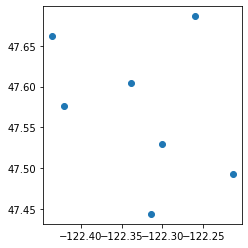

In [50]:
gdf_merged.plot()

In [51]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

# Make predictions
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)

# Calculate RMSE and R² for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate RMSE and R² for the testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Report the results
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")

Training RMSE: 432.31
Testing RMSE: 273.91
Training R²: 0.85
Testing R²: nan


/Users/amandaworthy/opt/anaconda3/envs/uwgda2022/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


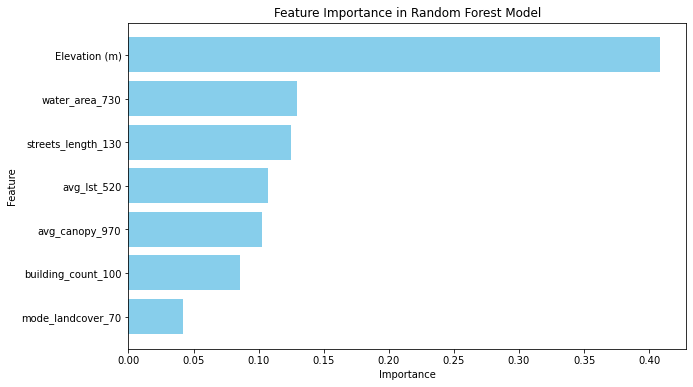

In [52]:
# Extract feature importances
importances = RF_model.feature_importances_
features= RF_model.feature_names_in_

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()
